In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import sklearn

# upper threshold for bets to be made
UPPER = 0.7

df = pd.read_csv('../../data/processed/engineered.csv')

df = df.sort_values('date')

models = []

## Initial set of columns

First I'm testing using some of the rolling average columns, a home team indicator, and the days of rest, and putting them in an XGBoost model

In [2]:
features = [
    'eFG_pct_avg_last_20', 'tov_rate_avg_last_20', 'oreb_pct_avg_last_20', 'ftr_avg_last_20',
    'ortg_avg_last_20', 'drtg_avg_last_20', 'covered_avg_last_20', 
    'eFG_pct_avg_last_10', 'tov_rate_avg_last_10', 'oreb_pct_avg_last_10', 'ftr_avg_last_10',
    'ortg_avg_last_10', 'drtg_avg_last_10', 'covered_avg_last_10', 
    # 'days_of_rest', 
    # 'opp_days_of_rest',
    'home_team', 
    'opp_ortg_avg_last_20', 'opp_drtg_avg_last_20',
    'opp_ortg_avg_last_10', 'opp_drtg_avg_last_10',
]


target = 'covered'

df[features].shape

(44697, 19)

In [3]:
print(df[target].value_counts(normalize=True))

covered
0    0.504821
1    0.495179
Name: proportion, dtype: float64


# Finding optimal parameters
Using optuna

In [4]:
import optuna
def objective(trial):
    X = df[features]
    y = df['covered']
    tscv = TimeSeriesSplit(n_splits=5)
    auc_scores, acc_scores = [], []
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold + 1}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        params = {
          'max_depth': trial.suggest_int('max_depth', 3, 8),
          'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
          'subsample': trial.suggest_float('subsample', 0.6, 1.0),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
          'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
          'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        }
        model = XGBClassifier(**params, n_estimators=1000, tree_method='hist', random_state=42)
        # run time-series CV and return mean AUC
        calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)

        calibrated_model.fit(X_train, y_train)

        # --- Predictions ---
        raw_preds = calibrated_model.predict_proba(X_test)[:, 1]
        preds = np.clip(raw_preds, 0.01, 0.99)
        auc = roc_auc_score(y_test, preds)
        acc = accuracy_score(y_test, (preds > 0.5).astype(int))

        auc_scores.append(auc)
        acc_scores.append(acc)


    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

c:\Users\Alexs\Desktop\projects\beat-the-books\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-15 13:26:58,035] A new study created in memory with name: no-name-f8f257d4-83f7-4b0f-b13a-fd7fee65487c
[W 2025-12-15 13:26:58,039] Trial 0 failed with parameters: {} because of the following error: NameError("name 'TimeSeriesSplit' is not defined").
Traceback (most recent call last):
  File "c:\Users\Alexs\Desktop\projects\beat-the-books\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Alexs\AppData\Local\Temp\ipykernel_7540\3781740986.py", line 5, in objective
    tscv = TimeSeriesSplit(n_splits=5)
           ^^^^^^^^^^^^^^^
NameError: name 'TimeSeriesSplit' is not defined
[W 2025-12-15 13:26:58,062] Trial 0 failed with value 

NameError: name 'TimeSeriesSplit' is not defined

## Baseline model

XGBClassifier with 10 game rolling averages of eFG%, tov_rate, oreb%, ftr, ortg, drtg, ATS, opp_ortg, opp_drtg.
Also including 

In [5]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


def train_model(features, df, calibration=None):
    # df = df.sort_values('date')

    X = df[features]
    y = df['covered']

    # Cross-validation for evaluation
    print("=" * 60)
    print("CROSS-VALIDATION RESULTS")
    print("=" * 60)

        
    # --- Setup ---
    tscv = TimeSeriesSplit(n_splits=5)
    auc_scores, acc_scores = [], []

    # Storage for calibration diagnostic
    all_prob_true, all_prob_pred = [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold + 1}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # --- Base model ---
        optim_params = {
            'max_depth': 3,
            'learning_rate': 0.01082724466797323,
            'subsample': 0.9086913680381073, 
            'colsample_bytree': 0.7890652096265818, 
            'reg_alpha': 4.418227287660602, 
            'reg_lambda': 0.02641759054496728}
        base_model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            enable_categorical=True,
            n_estimators=2000,
            learning_rate=optim_params['learning_rate'],
            max_depth=optim_params['max_depth'],
            min_child_weight=3,
            subsample=optim_params['subsample'],
            colsample_bytree=optim_params['colsample_bytree'],
            reg_lambda=optim_params['reg_lambda'],
            reg_alpha=optim_params['reg_lambda'],
            tree_method='hist',
        )

        # --- Calibration wrapper ---
        # Use Platt scaling (sigmoid); isotonic if large data
        calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)

        calibrated_model.fit(X_train, y_train)

        # --- Predictions ---
        raw_preds = calibrated_model.predict_proba(X_test)[:, 1]
        preds = np.clip(raw_preds, 0.01, 0.99)
        auc = roc_auc_score(y_test, preds)
        acc = accuracy_score(y_test, (preds > 0.5).astype(int))

        auc_scores.append(auc)
        acc_scores.append(acc)

        print(f"AUC: {auc:.3f} | Accuracy: {acc:.3f}")

        # for band in [(0,3),(3,7),(7,999)]:
        #     mask = X_test['spread_abs'].between(band[0], band[1])
        #     print(band, roc_auc_score(y_test[mask], preds[mask]))

        # Store calibration curve data for later aggregation
        prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=15)
        all_prob_true.append(prob_true)
        all_prob_pred.append(prob_pred)

    # --- Summary Metrics ---
    print(f"\nAverage AUC: {np.mean(auc_scores):.3f}")
    print(f"Average Accuracy: {np.mean(acc_scores):.3f}")

    # --- Combined Calibration Plot ---
    plt.figure(figsize=(7, 5))
    for i, (true, pred) in enumerate(zip(all_prob_true, all_prob_pred)):
        plt.plot(pred, true, marker='o', label=f'Fold {i+1}', alpha=0.6)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title("Calibration Curves (Per Fold)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    df.loc[test_idx, 'pred_prob'] = preds
    df = df.sort_values('date')

    return (df, calibrated_model)

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.817 | Accuracy: 0.740

Fold 2
AUC: 0.818 | Accuracy: 0.735

Fold 3
AUC: 0.798 | Accuracy: 0.718

Fold 4
AUC: 0.769 | Accuracy: 0.702

Fold 5
AUC: 0.787 | Accuracy: 0.710

Average AUC: 0.798
Average Accuracy: 0.721


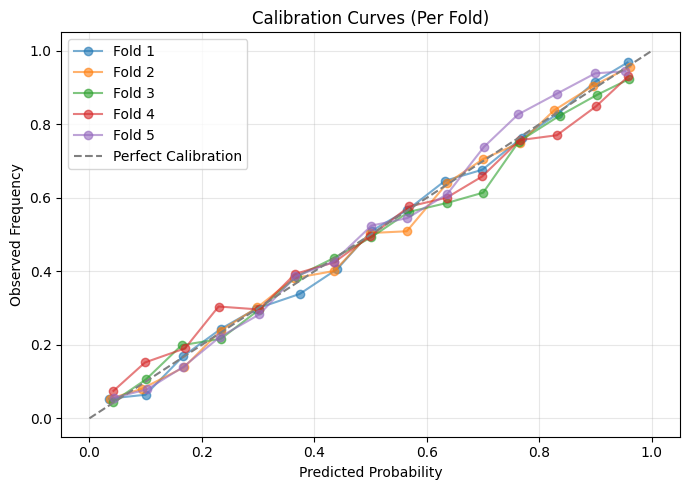

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

df['rest_category_encoded'] = df['rest_category'].astype('category')

categorical_features = ['rest_category_encoded']
all_f = features + categorical_features

rets = train_model(all_f, df)
df = rets[0]
model = rets[1]

models.append(model)

In [6]:
# from sklearn.calibration import calibration_curve
# prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
# plt.plot(prob_pred, prob_true, marker='o')
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Curve')
# plt.show()
# # used for testing, models look good so we should be fine

In [7]:
def compute_bets(df, upper_thresh=UPPER):
    # Simulate flat 1-unit bets
    df['bet_side'] = np.where(
        df['pred_prob'] > upper_thresh, 1,
        np.where(df['pred_prob'] < 1 - upper_thresh, 1, np.nan))

    # Only rows where we made a bet
    bets = df.dropna(subset=['bet_side']).copy()

    # Payouts assuming -110 odds
    WIN_PAYOUT = 0.9091  # profit per unit on win
    LOSS_PAYOUT = -1.0

    # Compute profit for each bet
    bets['bet_outcome'] = np.where(
        (bets['spread_abs'] < 7), 0, np.where(
        (bets['bet_side'] == bets['covered']), WIN_PAYOUT, LOSS_PAYOUT)
    )

    # Track cumulative bankroll
    bets['bankroll'] = bets['bet_outcome'].cumsum()

    return bets

In [8]:
def vis_bets(bets, upper_thresh=UPPER, WIN_PAYOUT=0.9091):
    total_bets = len(bets[bets['bet_outcome'] != 0])
    wins = (bets['bet_outcome'] == WIN_PAYOUT).sum()
    win_rate = wins / total_bets
    roi = bets['bankroll'].iloc[-1] / total_bets

    print(f"Based on betting on spreads where confidence > {upper_thresh*100}%")
    print(f"Total Bets: {total_bets}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"ROI per bet: {roi:.3f}")
    print(f"Total Units Won: {bets['bankroll'].iloc[-1]:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(bets['date'], bets['bankroll'], linewidth=2)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Baseline Model Betting Performance Over Time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Profit (Units)")
    plt.grid(True)
    plt.show()


C:\Users\Alexs\AppData\Local\Temp\ipykernel_7540\4178910413.py:4: RuntimeWarning: invalid value encountered in scalar divide
  win_rate = wins / total_bets
C:\Users\Alexs\AppData\Local\Temp\ipykernel_7540\4178910413.py:5: RuntimeWarning: invalid value encountered in scalar divide
  roi = bets['bankroll'].iloc[-1] / total_bets


Based on betting on spreads where confidence > 70.0%
Total Bets: 0
Win Rate: nan%
ROI per bet: nan
Total Units Won: 0.00


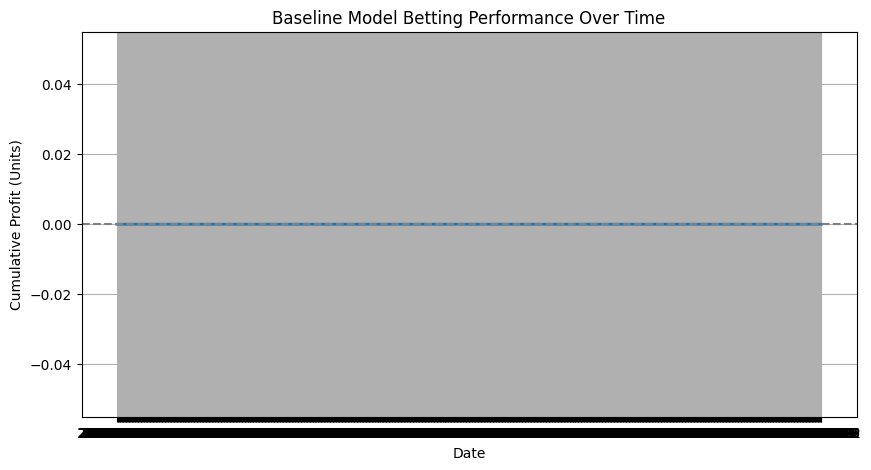

In [9]:
# df should already have:
# 'pred_prob' (model's predicted probability of covering)
# 'covered' (actual result, 1 or 0)
# 'spread' (for reference)
# 'date' (for time sorting)

df = df.sort_values('date')

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets, upper_thresh=UPPER)

## Adding a couple more things

Going to add bookie spread, difference in rest between teams (positive indicates more rest), and pace. 

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.860 | Accuracy: 0.775

Fold 2
AUC: 0.867 | Accuracy: 0.780

Fold 3
AUC: 0.856 | Accuracy: 0.773

Fold 4
AUC: 0.838 | Accuracy: 0.754

Fold 5
AUC: 0.859 | Accuracy: 0.775

Average AUC: 0.856
Average Accuracy: 0.772


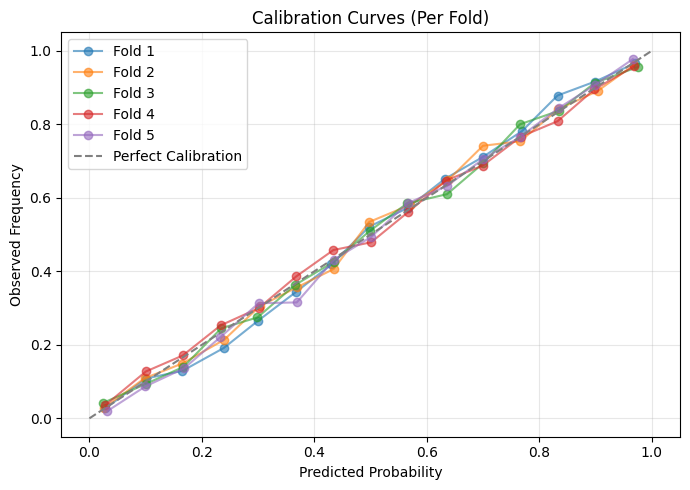

Based on betting on spreads where confidence > 70.0%
Total Bets: 4788
Win Rate: 49.50%
ROI per bet: -0.055
Total Units Won: -263.43


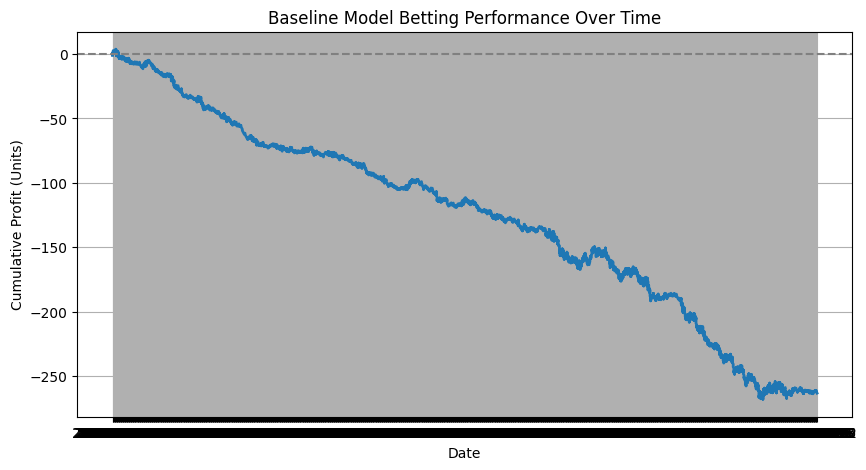

In [10]:
features = [
    'eFG_pct_avg_last_20', 'tov_rate_avg_last_20', 'oreb_pct_avg_last_20', 'ftr_avg_last_20',
    'ortg_avg_last_20', 'drtg_avg_last_20', 'covered_avg_last_20', 
    'eFG_pct_avg_last_5', 'tov_rate_avg_last_5', 'oreb_pct_avg_last_5', 'ftr_avg_last_5',
    'ortg_avg_last_5', 'drtg_avg_last_5', 'covered_avg_last_5', 
    'home_team', 
    'opp_ortg_avg_last_20', 'opp_drtg_avg_last_20',
    'opp_ortg_avg_last_5', 'opp_drtg_avg_last_5',
    'pace_diff', 'rest_diff', 'spread',
    'rest_category_encoded'
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')
df['rest_category_encoded'] = df['rest_category'].astype('category')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets= compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

## Model 3

Going to exclusively try the features I just created recently

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.696 | Accuracy: 0.641

Fold 2
AUC: 0.718 | Accuracy: 0.650

Fold 3
AUC: 0.687 | Accuracy: 0.629

Fold 4
AUC: 0.688 | Accuracy: 0.639

Fold 5
AUC: 0.702 | Accuracy: 0.647

Average AUC: 0.698
Average Accuracy: 0.641


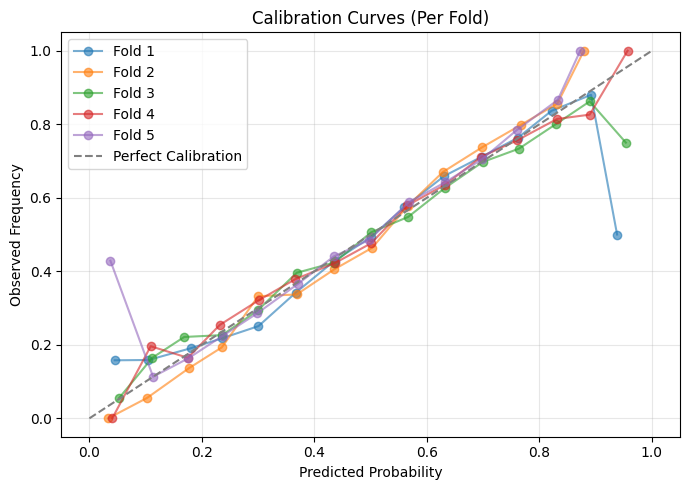

Based on betting on spreads where confidence > 70.0%
Total Bets: 1922
Win Rate: 49.22%
ROI per bet: -0.060
Total Units Won: -115.99


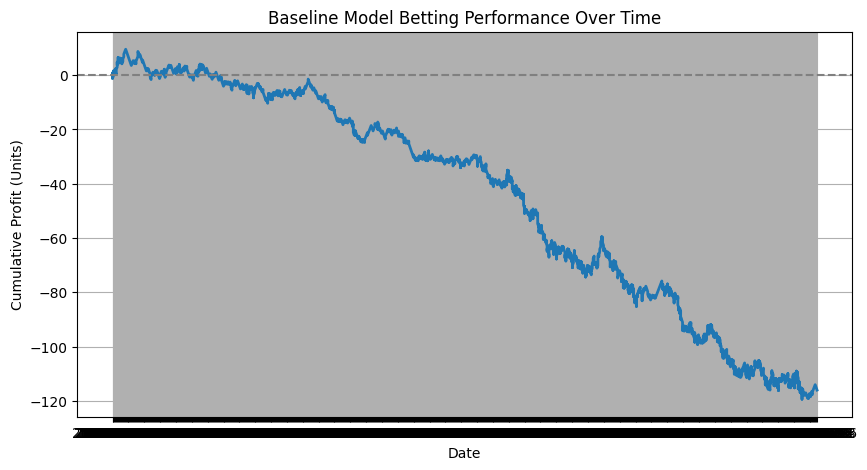

In [11]:
features = [
    'rest_diff',
    'pace_last_10', 'opp_pace_last_10',
    'adj_off_eff', 'adj_def_eff',
    'wl_last_10',
    'fatigue_index',
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

# Model 4

Every feature under the sun (what could go wrong lmao)

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.812 | Accuracy: 0.732

Fold 2
AUC: 0.812 | Accuracy: 0.732

Fold 3
AUC: 0.795 | Accuracy: 0.718

Fold 4
AUC: 0.768 | Accuracy: 0.694

Fold 5
AUC: 0.788 | Accuracy: 0.709

Average AUC: 0.795
Average Accuracy: 0.717


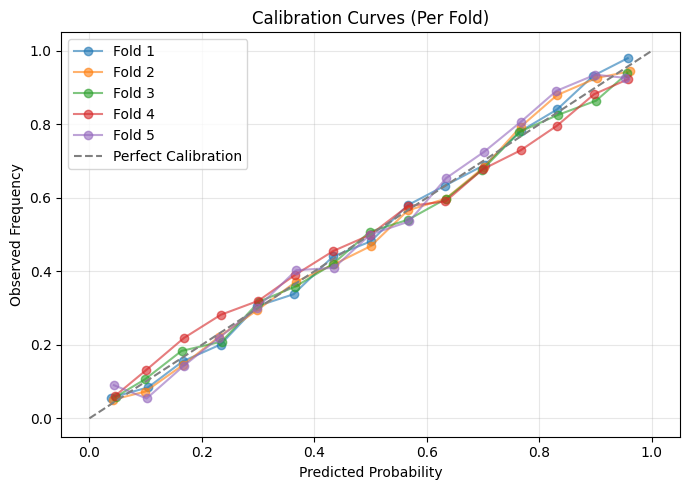

Based on betting on spreads where confidence > 70.0%
Total Bets: 3557
Win Rate: 49.79%
ROI per bet: -0.049
Total Units Won: -175.98


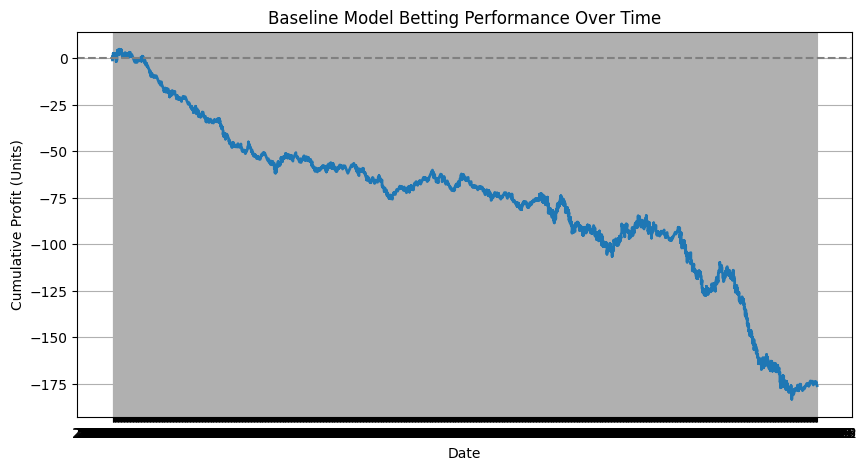

In [12]:
features = [
    'eFG_pct_avg_last_20', 'tov_rate_avg_last_20', 'oreb_pct_avg_last_20', 'ftr_avg_last_20',
    'ortg_avg_last_20', 'drtg_avg_last_20', 'covered_avg_last_20',     
    'opp_ortg_avg_last_20', 'opp_drtg_avg_last_20',
    'eFG_pct_avg_last_10', 'tov_rate_avg_last_10', 'oreb_pct_avg_last_10', 'ftr_avg_last_10',
    'ortg_avg_last_10', 'drtg_avg_last_10', 'covered_avg_last_10',     
    'opp_ortg_avg_last_10', 'opp_drtg_avg_last_10',
    'eFG_pct_avg_last_5', 'tov_rate_avg_last_5', 'oreb_pct_avg_last_5', 'ftr_avg_last_5',
    'ortg_avg_last_5', 'drtg_avg_last_5', 'covered_avg_last_5', 
    'opp_ortg_avg_last_5', 'opp_drtg_avg_last_5',
    'rebound_last_10_diff',
    'margin_avg_last_10', 'opp_margin_avg_last_10',
    'home_team', 
    # 'pace_diff', 
    'rest_diff',
    'pace_last_10', 'opp_pace_last_10',
    'adj_off_eff', 'adj_def_eff',
    'wl_last_10',
    'fatigue_index',
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')
# df_2['rest_category_encoded'] = df_2['rest_category'].astype('category')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

# Model 5

Ten most important features from model 4

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.703 | Accuracy: 0.647

Fold 2
AUC: 0.693 | Accuracy: 0.643

Fold 3
AUC: 0.676 | Accuracy: 0.629

Fold 4
AUC: 0.678 | Accuracy: 0.622

Fold 5
AUC: 0.699 | Accuracy: 0.634

Average AUC: 0.690
Average Accuracy: 0.635


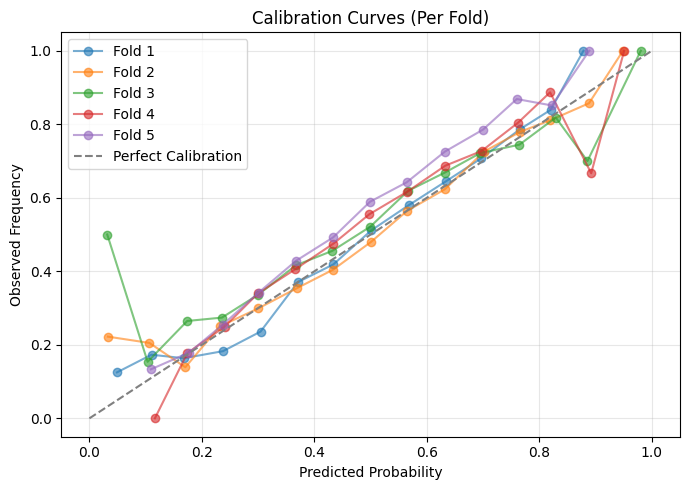

Based on betting on spreads where confidence > 70.0%
Total Bets: 2003
Win Rate: 49.08%
ROI per bet: -0.063
Total Units Won: -126.35


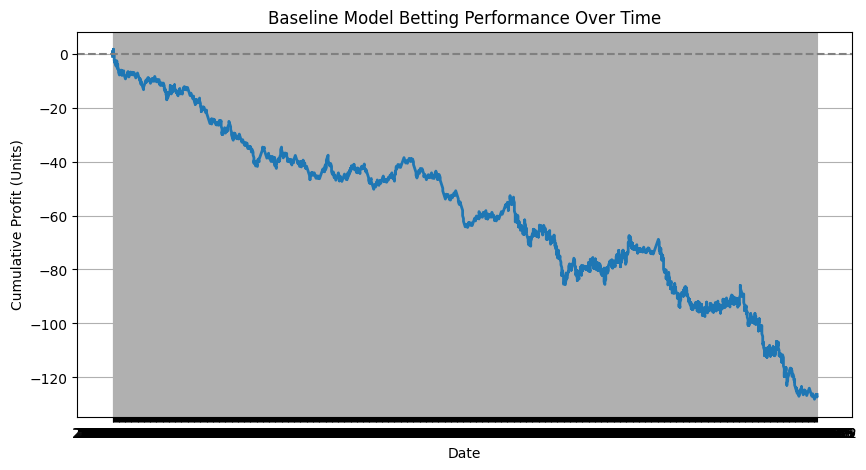

In [13]:
features = [
    'opp_pace_last_10',
    'opp_margin_avg_last_10',
    'pace_last_10',
    'ftr_avg_last_10',
    'tov_rate_avg_last_10',
    'oreb_pct_avg_last_10',
    'opp_ortg_avg_last_10',
    'opp_drtg_avg_last_10',
    'rebound_last_10_diff',
    'drtg_avg_last_10',
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')
# df_2['rest_category_encoded'] = df_2['rest_category'].astype('category')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

# Model 6

All features aside from opponent averages, hopefully opponent info is well carried by difference stats

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.801 | Accuracy: 0.724

Fold 2
AUC: 0.800 | Accuracy: 0.721

Fold 3
AUC: 0.784 | Accuracy: 0.706

Fold 4
AUC: 0.757 | Accuracy: 0.684

Fold 5
AUC: 0.778 | Accuracy: 0.704

Average AUC: 0.784
Average Accuracy: 0.708


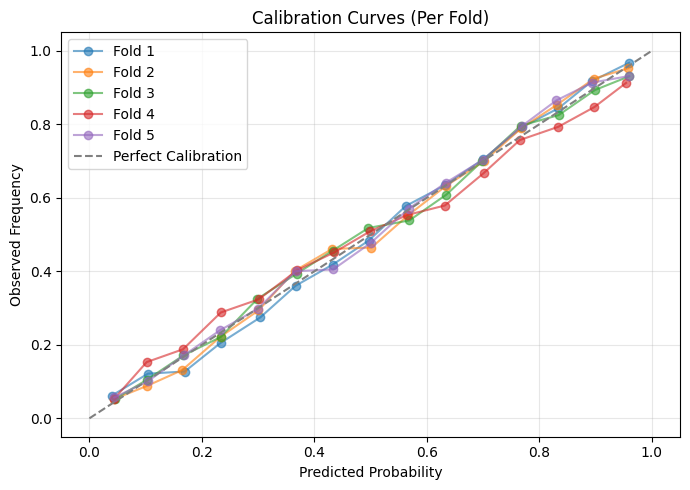

Based on betting on spreads where confidence > 70.0%
Total Bets: 3475
Win Rate: 50.01%
ROI per bet: -0.045
Total Units Won: -156.98


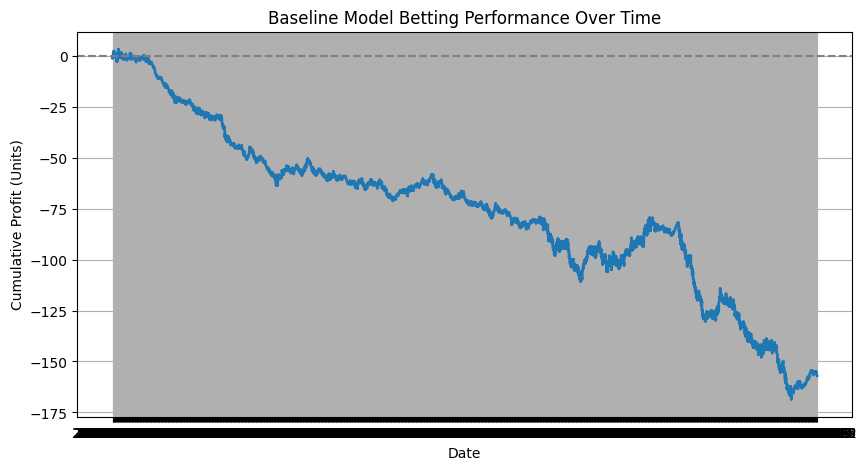

In [14]:
features = [
    'eFG_pct_avg_last_20', 'tov_rate_avg_last_20', 'oreb_pct_avg_last_20', 'ftr_avg_last_20',
    'ortg_avg_last_20', 'drtg_avg_last_20', 'covered_avg_last_20',
    'eFG_pct_avg_last_10', 'tov_rate_avg_last_10', 'oreb_pct_avg_last_10', 'ftr_avg_last_10',
    'ortg_avg_last_10', 'drtg_avg_last_10', 'covered_avg_last_10',    
    'eFG_pct_avg_last_5', 'tov_rate_avg_last_5', 'oreb_pct_avg_last_5', 'ftr_avg_last_5',
    'ortg_avg_last_5', 'drtg_avg_last_5', 'covered_avg_last_5', 
    'rebound_last_10_diff',
    'margin_avg_last_10',
    'home_team', 
    'pace_diff', 
    'rest_diff',
    'adj_off_eff', 'adj_def_eff',
    'wl_last_10',
    'fatigue_index',
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

# Model 7
Keeping only 10-day rolling averages from Model 6

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.792 | Accuracy: 0.720

Fold 2
AUC: 0.792 | Accuracy: 0.713

Fold 3
AUC: 0.775 | Accuracy: 0.697

Fold 4
AUC: 0.751 | Accuracy: 0.683

Fold 5
AUC: 0.772 | Accuracy: 0.697

Average AUC: 0.777
Average Accuracy: 0.702


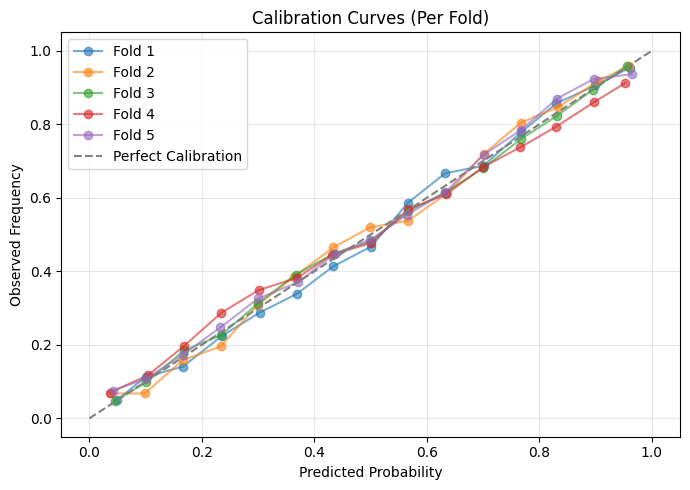

Based on betting on spreads where confidence > 70.0%
Total Bets: 3591
Win Rate: 49.99%
ROI per bet: -0.046
Total Units Won: -164.17


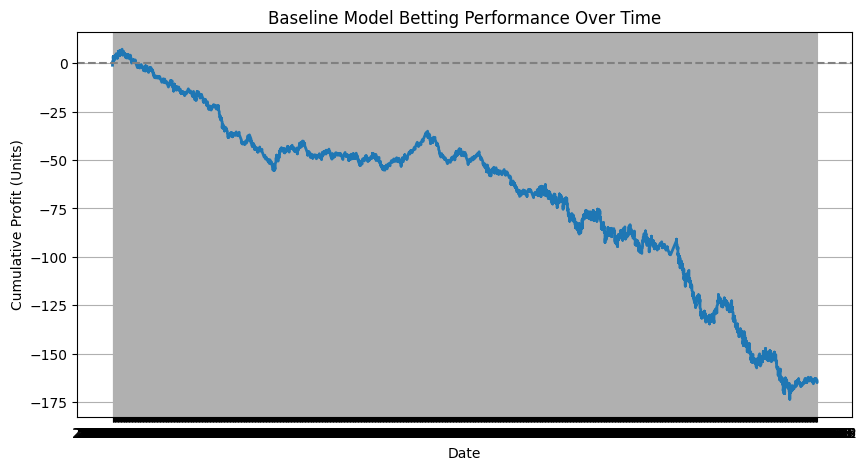

In [15]:
features = [
    'eFG_pct_avg_last_10', 'tov_rate_avg_last_10', 'oreb_pct_avg_last_10', 'ftr_avg_last_10',
    'ortg_avg_last_10', 'drtg_avg_last_10', 'covered_avg_last_10', 
    'rebound_last_10_diff',
    'margin_avg_last_10',
    'home_team', 
    'pace_diff', 
    'rest_diff',
    'adj_off_eff', 'adj_def_eff',
    'wl_last_10',
    'fatigue_index',
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

# Model 8
The ChatGPT approach (small subset to begin with)

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.863 | Accuracy: 0.778

Fold 2
AUC: 0.868 | Accuracy: 0.783

Fold 3
AUC: 0.857 | Accuracy: 0.780

Fold 4
AUC: 0.841 | Accuracy: 0.760

Fold 5
AUC: 0.859 | Accuracy: 0.775

Average AUC: 0.858
Average Accuracy: 0.775


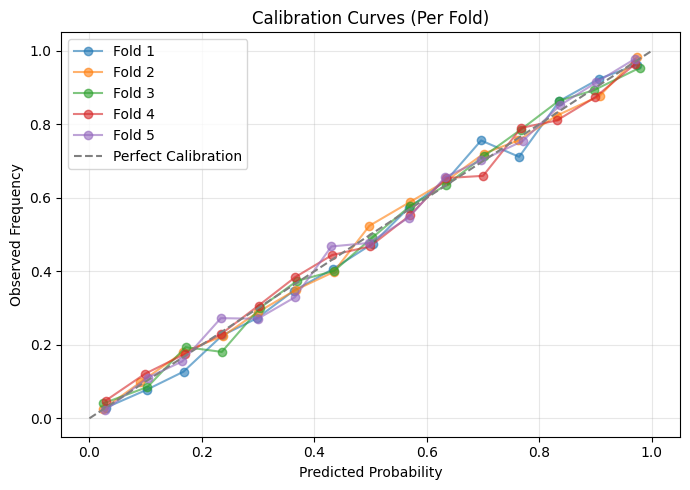

Based on betting on spreads where confidence > 70.0%
Total Bets: 4821
Win Rate: 49.35%
ROI per bet: -0.058
Total Units Won: -279.25


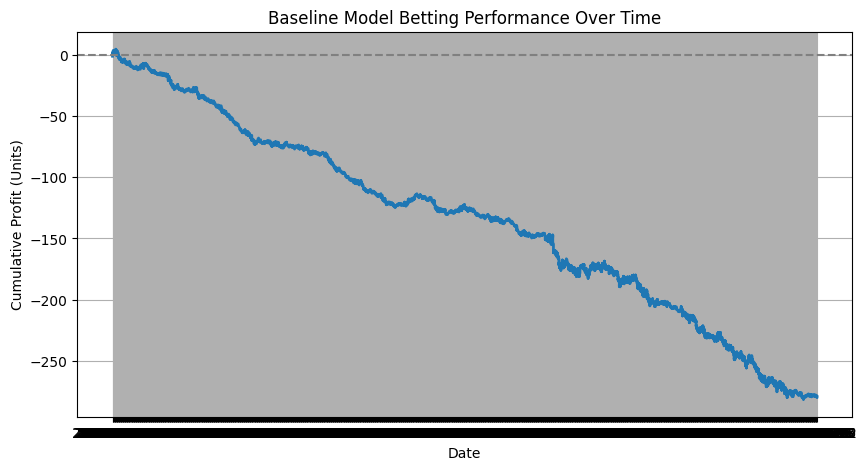

In [16]:
features = [
    'home_team',
    'spread',
    'days_of_rest',
    'rest_diff',
    'ortg_avg_last_10',
    'drtg_avg_last_10',
    'netrtg_avg_last_10',
    'wl_last_10',
    'adj_off_eff',
    'adj_def_eff',
    'rebound_last_10_diff',
    'pace_diff'
]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')

rets = train_model(features, df)
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

# Model 9
Iterating on model 8

CROSS-VALIDATION RESULTS

Fold 1
AUC: 0.870 | Accuracy: 0.787

Fold 2
AUC: 0.872 | Accuracy: 0.788

Fold 3
AUC: 0.860 | Accuracy: 0.781

Fold 4
AUC: 0.844 | Accuracy: 0.764

Fold 5
AUC: 0.863 | Accuracy: 0.779

Average AUC: 0.862
Average Accuracy: 0.780


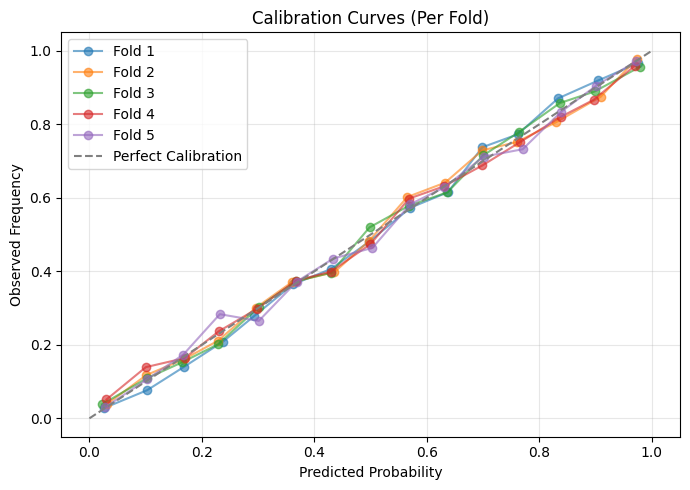

Based on betting on spreads where confidence > 70.0%
Total Bets: 1840
Win Rate: 49.02%
ROI per bet: -0.064
Total Units Won: -117.99


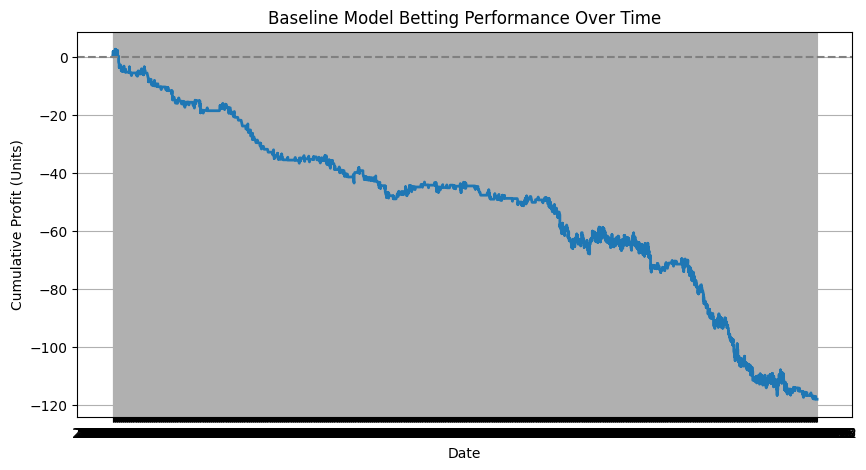

In [45]:
features = [
    'home_team',
    'spread',
    'days_of_rest',
    'rest_diff',
    'ortg_avg_last_10',
    'drtg_avg_last_10',
    'netrtg_avg_last_10',
    'wl_last_10',
    'adj_off_eff',
    'adj_def_eff',
    'rebound_last_10_diff',
    'pace_diff',
    'covered_avg_last_10',
    'spread_abs',

]

df = pd.read_csv('../../data/processed/engineered.csv')
df = df.sort_values('date')

rets = train_model(features, df, calibration='isotonic')
df = rets[0]
model = rets[1]

models.append(model)

bets = compute_bets(df, upper_thresh=UPPER)
vis_bets(bets)

In [18]:
# from xgboost import plot_importance
# for i, m in enumerate(models):
#     plot_importance(m, title=f'Model {i+1}')

covered
0    0.504821
1    0.495179
Name: proportion, dtype: float64


<Axes: xlabel='season'>

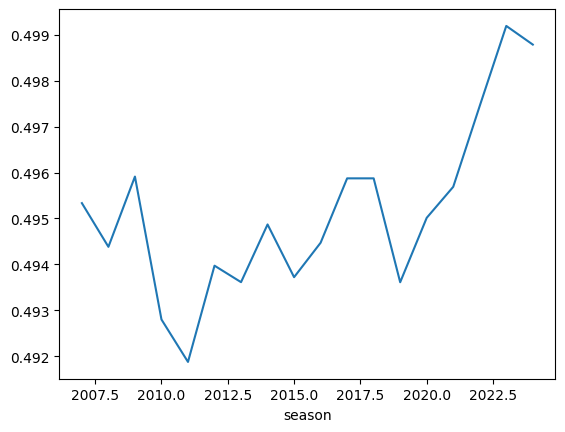

In [19]:
print(df[target].value_counts(normalize=True))
df.groupby('season')['covered'].mean().plot(kind='line')
